In [13]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
from skimage.io import imread, imsave
from matplotlib import pyplot as plt
from gradient_utils import GradientUtils
import pandas as pd
from plot_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load images
imgs_sw = imread(
    "/group/jug/aman/results/Results_usplit_64/PAVIA_ATN/windowed/pred_test_dset_pavia_usplit_windowed.tiff"
).transpose(0, 2, 3, 1)

imgs_og = imread(
    "/group/jug/aman/results/Results_usplit_64/PAVIA_ATN/original/pred_test_dset_pavia_usplit_og_64.tiff"
).transpose(0, 2, 3, 1)

In [14]:
# create instances
grad_utils_sw = GradientUtils(imgs_sw, tile_size=32)
grad_utils_og = GradientUtils(imgs_og, tile_size=32)

# extract gradients modularly
grad_sw_edge = grad_utils_sw.get_gradients_at("edge", channels = 1)
grad_sw_mid = grad_utils_sw.get_gradients_at("middle", channels = 1)
grad_og_edge = grad_utils_og.get_gradients_at("edge", channels = 1)
grad_og_mid = grad_utils_og.get_gradients_at("middle", channels = 1)

# create shared bin edges using gradients at all the positions middle and edge
_, bin_edges = np.histogram(
    np.concatenate([grad_og_mid, grad_sw_mid, grad_og_edge, grad_sw_edge]),
    bins=2000)

In [21]:
# re-init with shared bins
grad_utils_sw = GradientUtils(imgs_sw, tile_size=32, bin_edges=bin_edges)
grad_utils_og = GradientUtils(imgs_og, tile_size=32, bin_edges=bin_edges)

In [46]:
data = {
    "Original Method": grad_utils_og.get_peakiness_scores(grad_utils_og.histogram_edges,grad_utils_og.histogram_middle)[-1],
    "Sliding Window Method": grad_utils_sw.get_peakiness_scores(grad_utils_sw.histogram_edges,grad_utils_sw.histogram_middle)[-1]
}
df = pd.DataFrame(data, index=["Peakiness Score for Histogram Middle Vs Histogram Edge |"])
df['∆ between two methods'] = df['Sliding Window Method'] -  df['Original Method']
print("Peakiness Scores of Difference of Gradient Histograms computed at Edge Vs Middle of Tiles (Lower is better):")
print("______________________________________________________________________________________________________________")
print(df.to_string())
if df['∆ between two methods'].iloc[0] < 0:
    print("\nSliding Window Method performs better than Original Method since it has lower Peakiness Score. ✅")


Peakiness Scores of Difference of Gradient Histograms computed at Edge Vs Middle of Tiles (Lower is better):
______________________________________________________________________________________________________________
                                                          Original Method  Sliding Window Method  ∆ between two methods
Peakiness Score for Histogram Middle Vs Histogram Edge |         0.952662                0.74606              -0.206602

Sliding Window Method performs better than Original Method since it has lower Peakiness Score. ✅


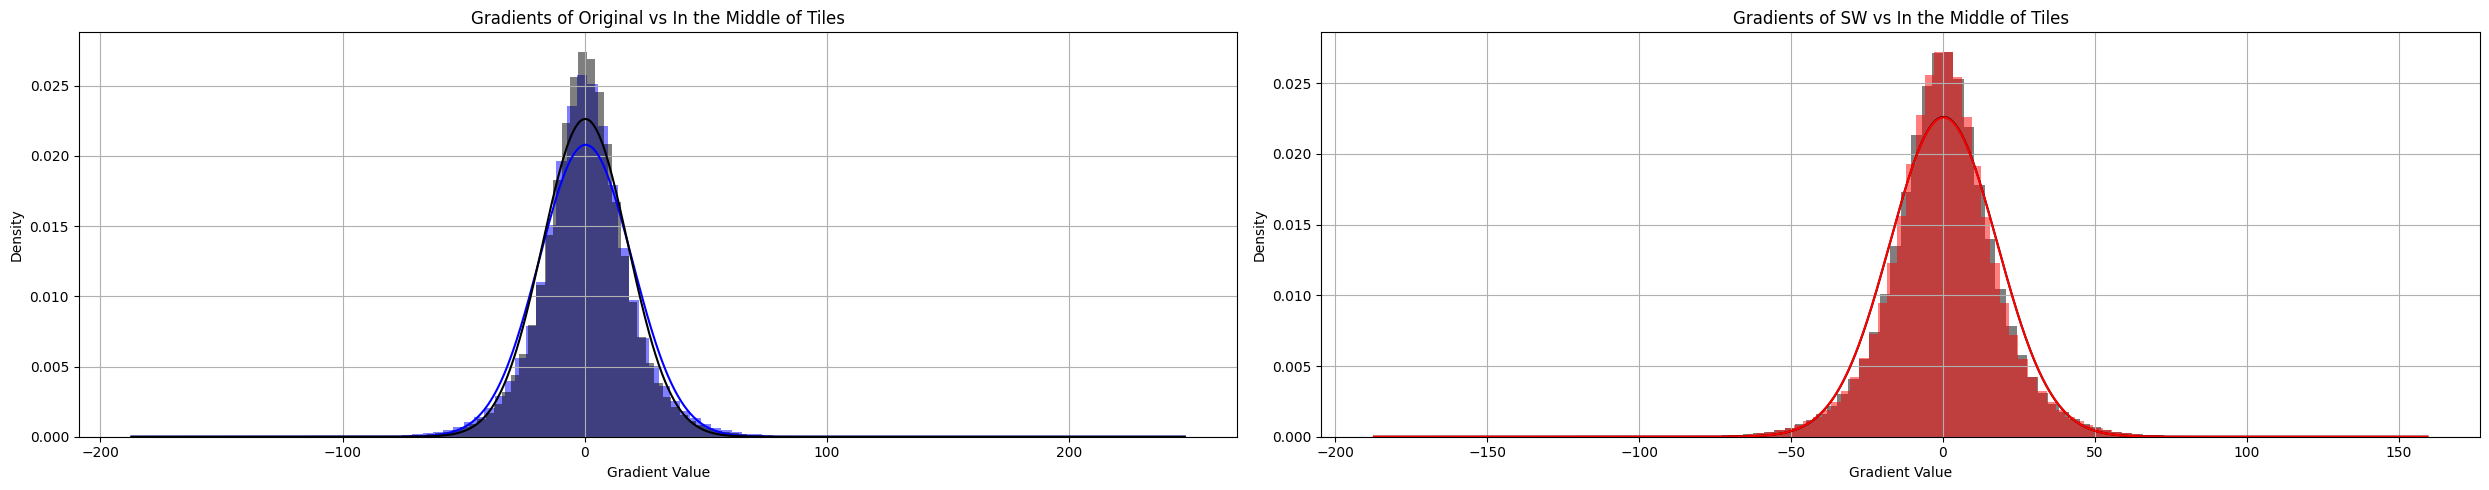

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5))

# Row 1 = Not-normalized (raw gradients)
plot_multiple_hist(
    axs[0],
    arrays=[grad_og_edge, grad_og_mid],
    labels=["Gradient at Edges", "Gradients at middle of tiles"],
    colors=["blue", "black"],
    title="Gradients of Original vs In the Middle of Tiles"
)

plot_multiple_hist(
    axs[1],
    arrays=[grad_sw_mid, grad_sw_edge],
    labels=["Gradients at middle of tiles", "Gradient at Edges"],
    colors=["black", "red"],
    title="Gradients of SW vs In the Middle of Tiles"
)

plt.tight_layout()
plt.show()

/tmp/ipykernel_40153/399983616.py:47: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


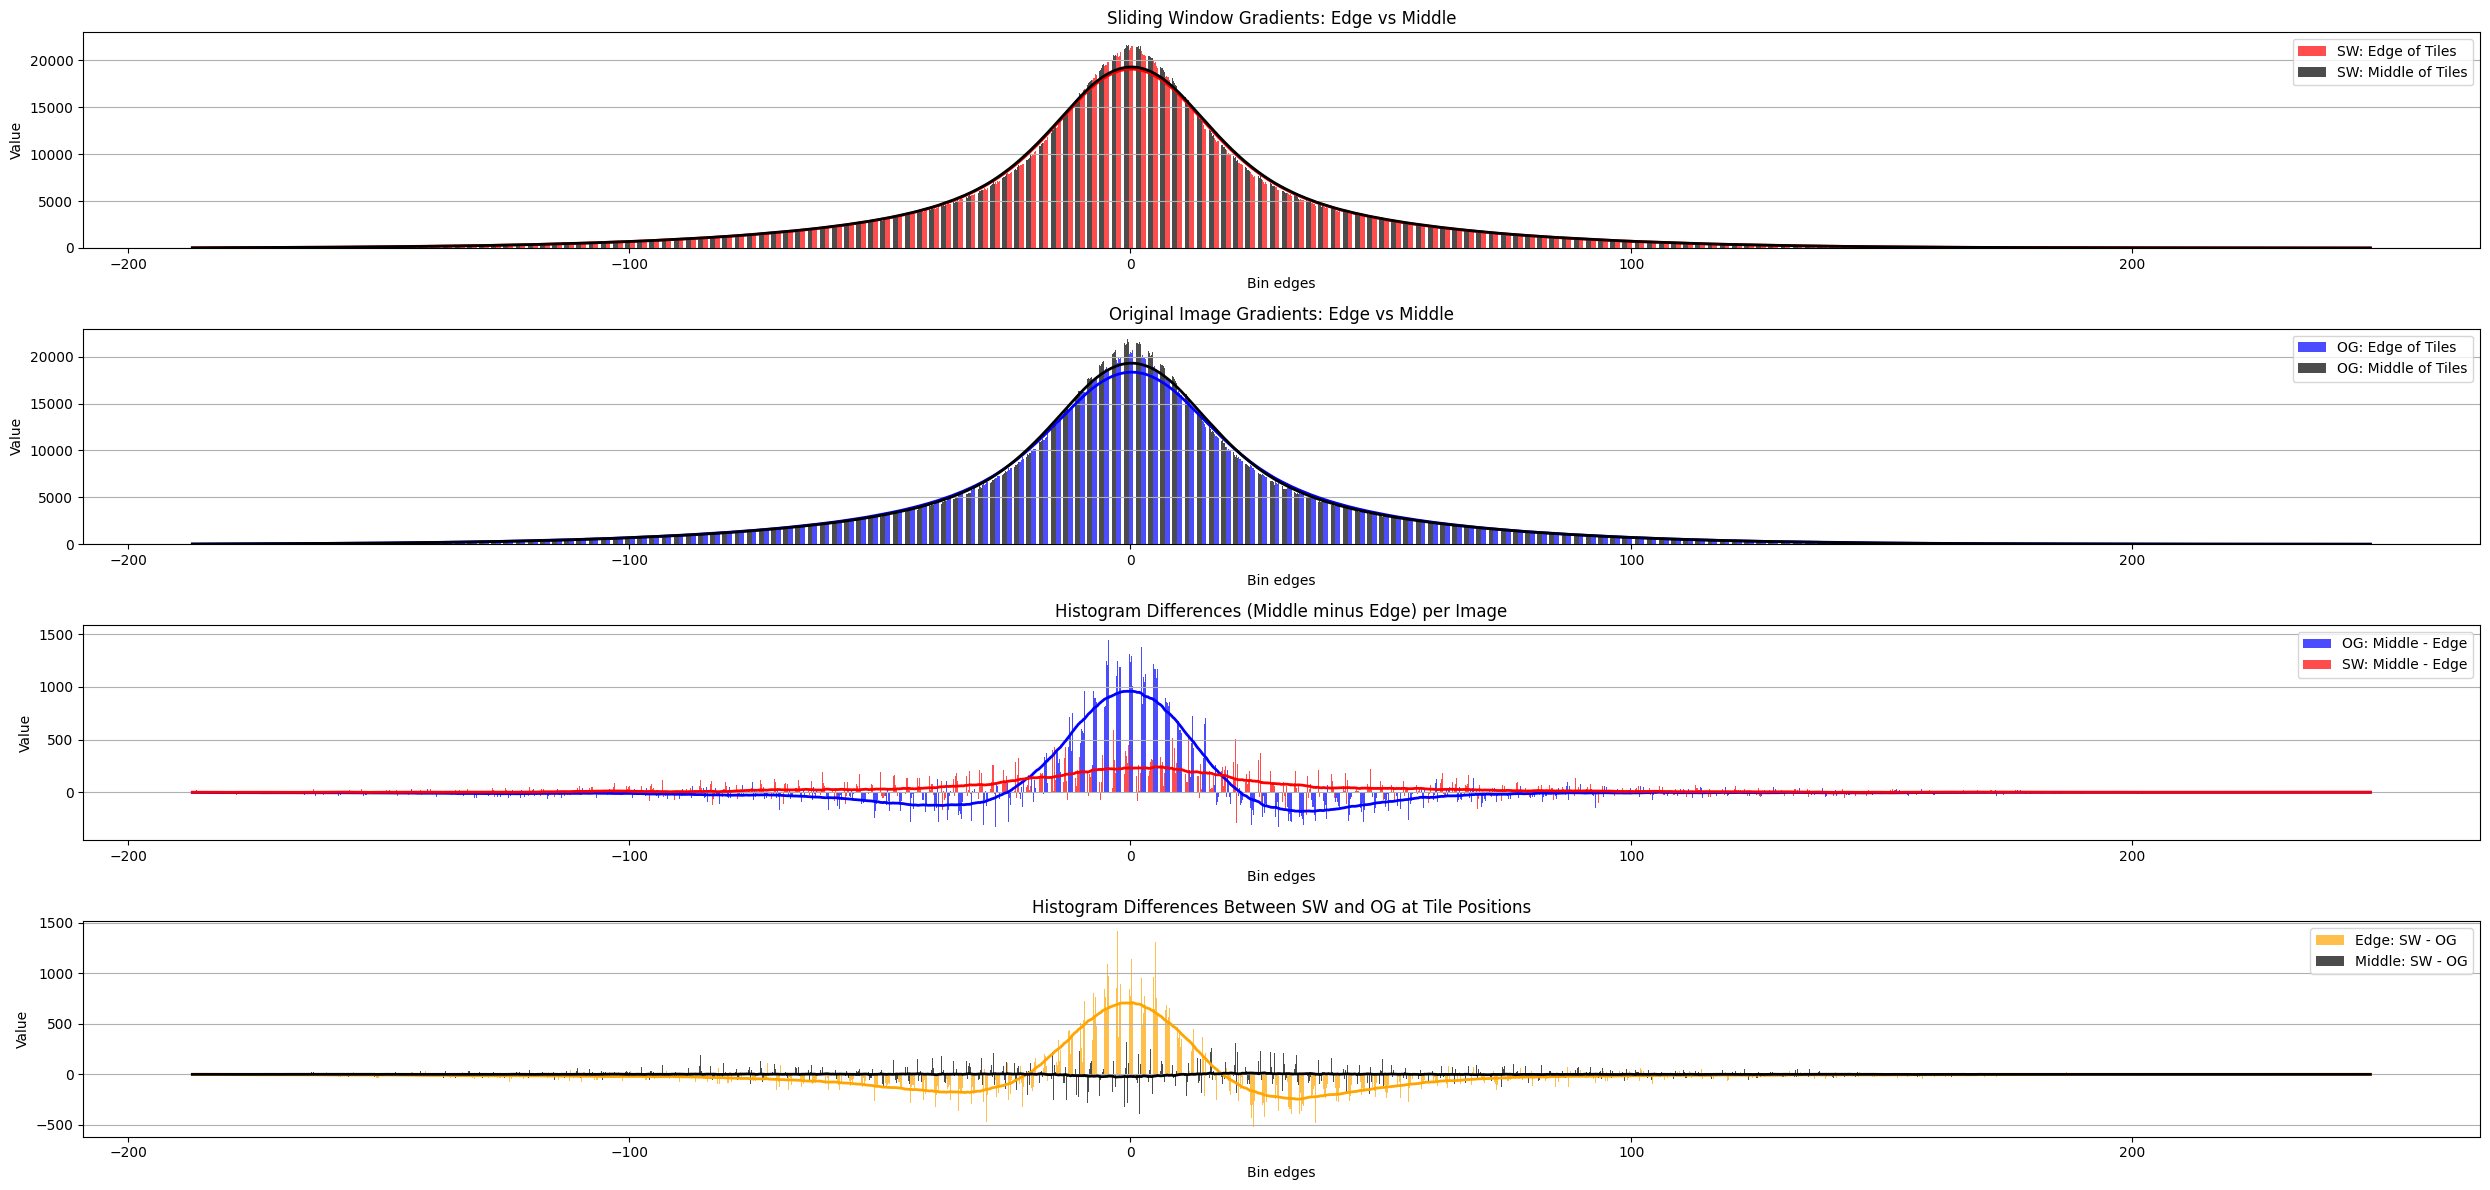

In [48]:
fig, ax = plt.subplots(4, 1, figsize=(25, 12))

#
plot_multiple_bar(
    ax[0],
    arrays=[grad_utils_sw.histogram_edges, grad_utils_sw.histogram_middle],
    labels=["SW: Edge of Tiles", "SW: Middle of Tiles"],
    colors=["red", "black"],
    title="Sliding Window Gradients: Edge vs Middle",
    smooth_window=100,
    bin_edges=bin_edges[:-1]
)


plot_multiple_bar(
    ax[1],
    arrays=[grad_utils_og.histogram_edges, grad_utils_og.histogram_middle],
    labels=["OG: Edge of Tiles", "OG: Middle of Tiles"],
    colors=["blue", "black"],
    title="Original Image Gradients: Edge vs Middle",
    smooth_window=100,
    bin_edges=bin_edges[:-1]
)

plot_multiple_bar(
    ax[2],
    arrays=[grad_utils_og.histogram_middle - grad_utils_og.histogram_edges, 
            grad_utils_sw.histogram_middle - grad_utils_sw.histogram_edges],
    labels=["OG: Middle - Edge", "SW: Middle - Edge"],
    colors=["blue", "red"],
    title="Histogram Differences (Middle minus Edge) per Image",
    smooth_window=100,
    bin_edges=bin_edges[:-1]
)

plot_multiple_bar(
    ax[3],
    arrays=[grad_utils_sw.histogram_edges - grad_utils_og.histogram_edges, 
            grad_utils_sw.histogram_middle - grad_utils_og.histogram_middle],
    labels=["Edge: SW - OG", "Middle: SW - OG"],
    colors=["orange", "black"],
    title="Histogram Differences Between SW and OG at Tile Positions",
    smooth_window=100,
    bin_edges=bin_edges[:-1]
)

plt.tight_layout()
plt.show()

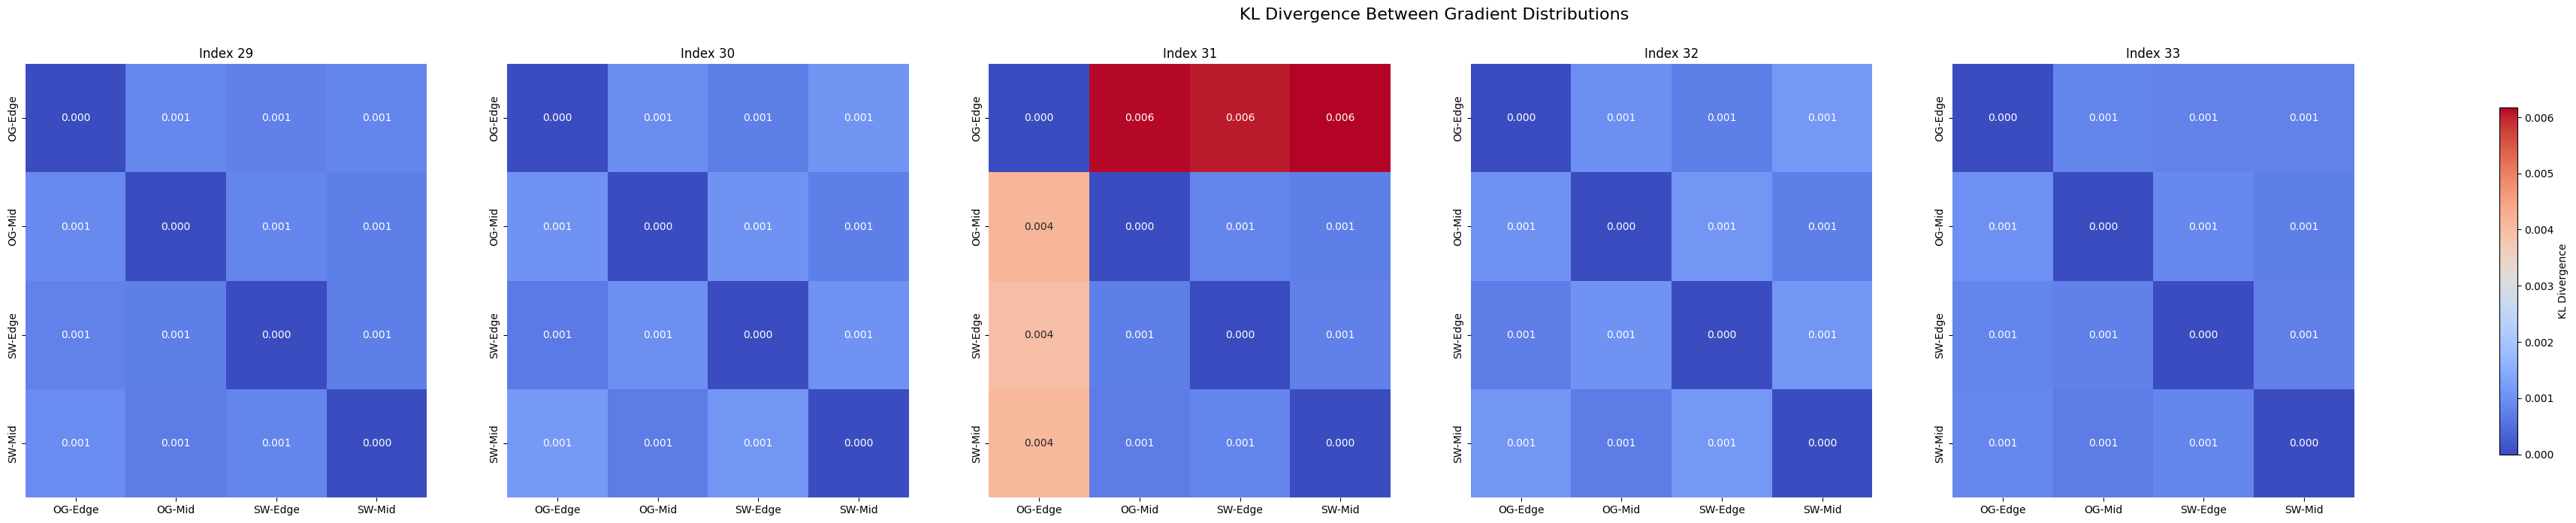

In [49]:
plot_kl_heatmaps_for_range(
    grad_utils_list=[grad_utils_og, grad_utils_sw],
    bin_edges=bin_edges,
    start=29, end=33,
    channels=1,
    labels=["OG", "SW"]
)